# Basic Plots

In [1]:
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as mpatches
from tqdm import tqdm

from misc_util.logutils import setup_logging
from misc_util.pretty_print import Markdown, display

from derive_conceptualspace.util.mpl_tools import show_hist
from derive_conceptualspace.pipeline import SnakeContext, load_envfiles,  load_lang_translate_files
from derive_conceptualspace.create_spaces.preprocess_descriptions import preprocess_descriptions_full
from fb_classifier.preprocess_data import make_classifier_dict, make_classifier_class
from derive_conceptualspace.load_data.dataset_specifics.siddata2022 import Dataset

flatten = lambda l: [item for sublist in l for item in sublist]
plt.rcParams['figure.figsize'] = [16, 10]
largedfstyle = [dict(selector="th", props= [('font-size', '18px')]), dict(selector="td", props= [('font-size', '18px')])]

In [2]:
setup_logging()
load_envfiles("siddata")
ctx = SnakeContext.loader_context(config=dict(MIN_WORDS_PER_DESC=0, debug=False), silent=False)

<span style="font-size:11pt">env_vars demanded config MIN_WORDS_PER_DESC to be <span style="color: #ff0000">80</span>, but force overwrites it to <span style="color: #0000ff">0</span></span>

<span style="font-size:11pt">Config-File /home/chris/Documents/UNI_neu/Masterarbeit/Derive_Conceptualspace/config/derrac2015_edited.yml loaded.</span>

<span style="font-size:11pt">Running with the following settings [<span style="color: #ff00ff">d82202bedd</span>]: CLASSIFIER: <span style="color: #0000ff">SVM</span>, CLASSIFIER_SUCCMETRIC: <span style="color: #ff0000">kappa_count2rank_onlypos</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #0000ff">count</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #ff0000">3</span>, EXTRACTION_METHOD: <span style="color: #ff0000">tfidf</span>, KAPPA_WEIGHTS: <span style="color: #0000ff">quadratic</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">0</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, PRIM_LAMBDA: <span style="color: #0000ff">0.5</span>, QUANTIFICATION_MEASURE: <span style="color: #ff0000">ppmi</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, SEC_LAMBDA: <span style="color: #ff0000">0.2</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

In [3]:
raw_descriptions = ctx.p.load(ctx.get_config("raw_descriptions_file"), "raw_descriptions")
languages, translations = load_lang_translate_files(ctx, ctx.p, ctx.get_config("pp_components"))
descriptions, _ = preprocess_descriptions_full(raw_descriptions, ctx.obj["dataset_class"], ctx.get_config("pp_components"), "de", 
                             ctx.get_config("translate_policy"), languages, verbose=False)

<span style="font-size:11pt">The following Pre-Processings will be performed: sentwise_merge, add_additionals, add_title, add_subtitle, remove_htmltags, convert_lower, remove_stopwords, remove_diacritics, use_skcountvec</span>

pre-preprocessing descriptions: 100%|██████████| 30841/30841 [02:07<00:00, 241.81it/s] 


<span style="font-size:11pt">Dropped 4495 out of 30841 descriptions because I will take only the ones of language de (26346 left)</span>

Removed 0 of 26346 Descriptions because they are less than 0 words (26346 left)


# Words per Description

In [4]:
%%capture
fig, ax = show_hist([i.n_words() for i in descriptions._descriptions], "Words per Description", xlabel="Number of Words", cutoff_percentile=98, no_plot=False, 
                    fig_kwargs=dict(figsize=(16, 6)))

In [5]:
ax.get_xticklabels()[-1].set_text(ax.get_xticklabels()[-1].get_text().replace("-","-\n"))
ax.set_ylabel("Count of Descriptions", fontsize=28)
ax.set_xlabel("Number of Words", fontsize=28)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=24)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=24)
ax.grid()
ax.set_title("");

/tmp/ipykernel_218397/1550197324.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator


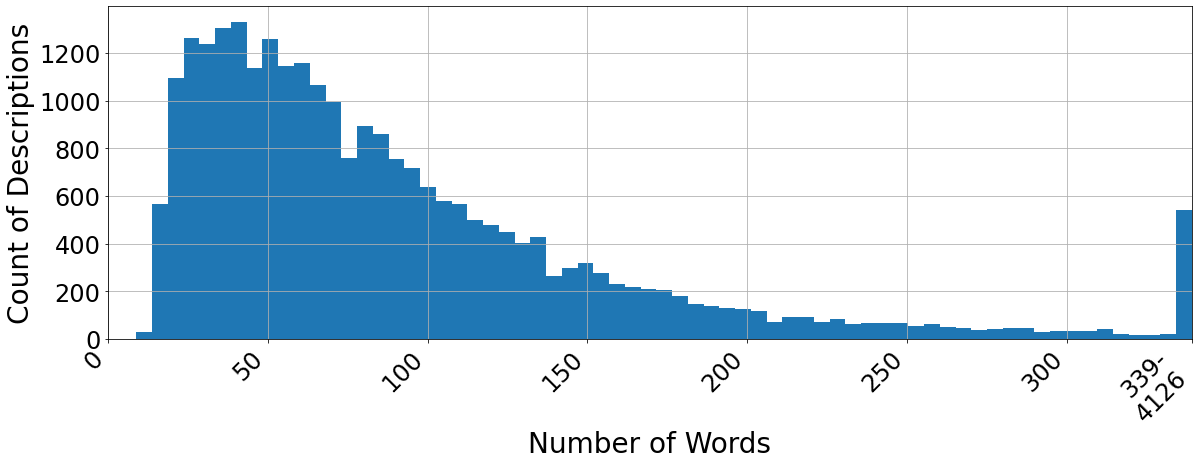

In [6]:
with PdfPages("/home/chris/Documents/UNI_neu/Masterarbeit/MastersThesisText/graphics/dataset_new/words_per_desc.pdf") as pdf:
    plt.show()
    pdf.savefig(fig, bbox_inches='tight')
    
fig

In [7]:
vecs = {i.title: i.bow() for i in descriptions._descriptions}
all_words = set(flatten([set(k.keys()) for k in vecs.values()]))
summed_counts = {i: {"df": 0, "stf": 0} for i in all_words}
for v in tqdm(vecs.values()):
    for word, occs in v.items():
        summed_counts[word]["stf"] += occs
        summed_counts[word]["df"] += 1
words_of_len = {key: {nwords: len({k: v for k, v in summed_counts.items() if v[key] >= nwords}) for nwords in [1, 2, 5, 10, 25, 50, 100, 500, 1000, len(vecs)//10, len(vecs)//4]} for key in ["df", "stf"]}
display(Markdown("### Number of words that have a df or stf of at least..."))
pd.DataFrame(words_of_len).T.style.set_table_styles(largedfstyle)

100%|██████████| 26346/26346 [00:01<00:00, 15533.84it/s]


### Number of words that have a df or stf of at least...

,1,2,5,10,25,50,100,500,1000,2634,6586
df,163285,80802,35697,20238,9702,5535,3059,570,210,23,2
stf,163285,87840,40998,23802,11619,6649,3722,765,317,60,8


In [8]:
vecs = {i.title: i.bow() for i in descriptions._descriptions}
counts = pd.DataFrame({k: {"unique words": len(v), "words": sum(v.values())} for k, v in vecs.items()}).T
aggs = counts.agg((min, np.mean, np.median, min), axis="rows")
aggs = pd.concat((aggs, counts.quantile([.05, .95])))
aggs.astype(int).style.set_table_styles(largedfstyle)

,unique words,words
min,7,9
mean,72,94
median,60,71
min,7,9
0.050000,19,22
0.950000,169,239


In [9]:
vecs = {i.title: i.bow() for i in descriptions._descriptions if sum(i.bow().values()) >= 80}
counts = pd.DataFrame({k: {"unique words": len(v), "words": sum(v.values())} for k, v in vecs.items()}).T
aggs = counts.agg((min, np.mean, np.median, min), axis="rows")
aggs = pd.concat((aggs, counts.quantile([.05, .95])))
aggs.astype(int).style.set_table_styles(largedfstyle)

,unique words,words
min,29,80
mean,113,155
median,99,124
min,29,80
0.050000,63,83
0.950000,211,323


# #Descriptions per Fachbereich

2022-03-30, 17:35:25.000503 INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2022-03-30, 17:35:25.000507 INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Dropped 10520/26346 (39.93%) courses


/tmp/ipykernel_218397/1284847027.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


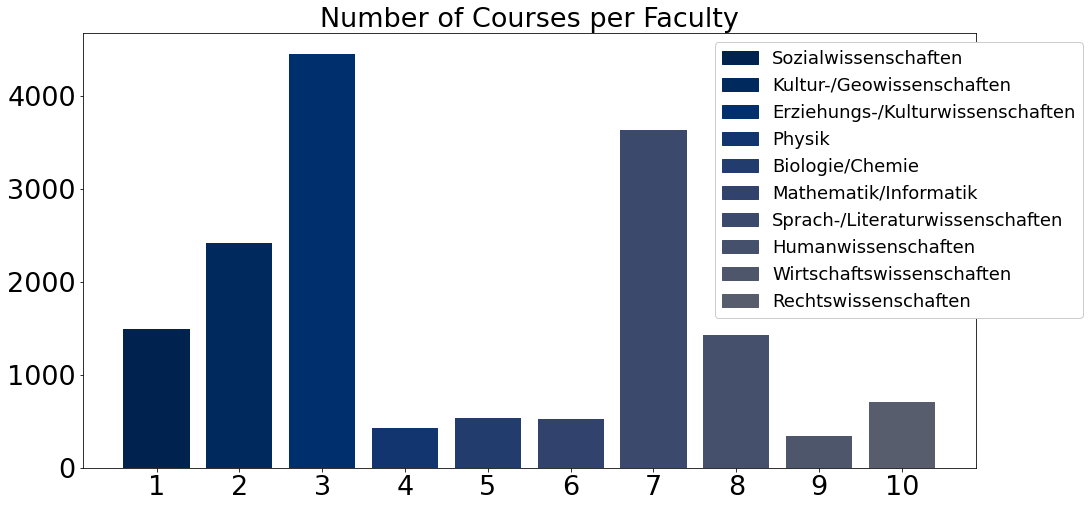

In [10]:
#TODO this functionality is also in the Dataset-class of siddata2022, use that one!
veranst_nums = [eval(i._additionals.get("veranstaltungsnummer")) or None for i in descriptions._descriptions]
new_dset = make_classifier_dict(dict(enumerate(veranst_nums)))
usables = {k: [int(v) for v in vs if v != "other" and int(v) <= 10] for k, vs in new_dset.items() if vs != "other"}
usables = {k: v for k, v in usables.items() if v and any(i is not None for i in v)}
print(f"Dropped {len(new_dset)-len(usables)}/{len(new_dset)} ({(len(new_dset)-len(usables))/len(new_dset)*100:.2f}%) courses")
counter = {str(k): v for k, v in sorted(Counter(flatten([i for i in usables.values()])).items(), key=lambda x:int(x[0]))}
#counter["Other"] = len(new_dset)-len(usables)


fig, ax = plt.subplots(figsize=(16,8))
rescale = lambda y, fac=1: (y - np.min(y)) / (np.max(y)*fac - np.min(y))
ax.bar(*list(zip(*counter.items())), color=plt.get_cmap("cividis")(rescale(range(len(counter)),fac=3)))
ax.set_title(f"Number of Courses per Faculty")
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(27)
    
patches = [mpatches.Patch(label=v, color=col) for v, col in zip(Dataset.FB_MAPPER.values(), plt.get_cmap("cividis")(rescale(range(len(counter)),fac=3)))]
plt.legend(handles=patches, fontsize=18, bbox_to_anchor=(1.13, .999), framealpha=1)

with PdfPages("/home/chris/Documents/UNI_neu/Masterarbeit/MastersThesisText/graphics/dataset_new/courses_per_faculty.pdf") as pdf:
    fig.show()
    pdf.savefig(fig, bbox_inches='tight')